Tensor core matrix multiplication tests all pass; fp32 version is about 48x faster in a*a matrix multiplication, with strided showing the clearest performance gain on other tests. Some tests are so short that they might not offer much insight.

In [3]:
# initialise fortran library for tensor core version; split/join only
import numpy as np
import cupy as cp
import ctypes
import time

# Load the shared library
lib = ctypes.CDLL('./cuda_matlib.so')

# Define argument types - important change here to use c_void_p for device pointers
lib.py_matrix_dot.argtypes = [
    ctypes.c_void_p,    # Device pointer for input
    ctypes.c_void_p,    # Device pointer for output
    ctypes.c_int,       # n
    ctypes.c_int        # iterations
]

def cuda_dot_tensor(a, iterations=1000):
    """Fast matrix power using CUDA Fortran with tensor cores"""
    if not isinstance(a, (np.ndarray, cp.ndarray)):
        raise TypeError("Input must be a numpy or cupy array")
    
    # Convert to cupy array if needed
    if isinstance(a, np.ndarray):
        a_gpu = cp.array(a, dtype=cp.float64)
    else:
        a_gpu = cp.asarray(a, dtype=cp.float64)
    
    if a_gpu.shape[0] != a_gpu.shape[1]:
        raise ValueError("Matrix must be square")
    
    # Ensure contiguous memory layout
    if not a_gpu.flags['C_CONTIGUOUS']:
        a_gpu = cp.ascontiguousarray(a_gpu)
    
    n = a_gpu.shape[0]
    result_gpu = cp.empty_like(a_gpu)
    
    # Get device pointers
    a_ptr = ctypes.c_void_p(a_gpu.data.ptr)
    result_ptr = ctypes.c_void_p(result_gpu.data.ptr)
    
    # Call CUDA Fortran function with device pointers
    lib.py_matrix_dot(a_ptr, result_ptr, n, iterations)
    
    # Return numpy array if input was numpy
    if isinstance(a, np.ndarray):
        return cp.asnumpy(result_gpu)
    return result_gpu

# create a random numpy array of size 1000x1000 and scale it
a_np = np.random.rand(1000, 1000)
# Modified scaling
a_np = np.random.rand(1000, 1000)
scale_factor = np.linalg.norm(a_np)
a_np = a_np / (scale_factor * np.power(1.1, 1/1000))  # More gradual scaling

a_cp = cp.array(a_np)  # same scaled data for CuPy
a_cuda = a_np.copy()   # same scaled data for CUDA Fortran

# NumPy test
start = time.time()
result_numpy = a_np.copy()
for i in range(1000):  
    result_numpy = np.dot(result_numpy, a_np)
numpy_time = time.time() - start
print(f"Time taken by NumPy: {numpy_time:.3f} seconds")

# CuPy test
start = time.time()
result_cupy = a_cp.copy()
for i in range(1000):  
    result_cupy = cp.dot(result_cupy, a_cp)
result_cupy = cp.asnumpy(result_cupy)
cupy_time = time.time() - start
print(f"Time taken by CuPy: {cupy_time:.3f} seconds")

# CUDA Fortran test
start = time.time()
result_cuda = cuda_dot_tensor(a_cuda, 1000)
cuda_time = time.time() - start
print(f"Time taken by CUDA Fortran: {cuda_time:.3f} seconds")

print("\nChecking results (first few elements):")
print("NumPy result:")
print(result_numpy[0:2, 0:2])
print("\nCuPy result:")
print(result_cupy[0:2, 0:2])
print("\nCUDA Fortran result:")
print(result_cuda[0:2, 0:2])

print("\nChecking for infinities or NaNs:")
print(f"NumPy contains inf: {np.isinf(result_numpy).any()}")
print(f"NumPy contains NaN: {np.isnan(result_numpy).any()}")
print(f"CuPy contains inf: {np.isinf(result_cupy).any()}")
print(f"CuPy contains NaN: {np.isnan(result_cupy).any()}")
print(f"CUDA contains inf: {np.isinf(result_cuda).any()}")
print(f"CUDA contains NaN: {np.isnan(result_cuda).any()}")

if not (np.isinf(result_numpy).any() or np.isinf(result_cupy).any() or np.isinf(result_cuda).any()):
    print("\nAccuracy comparison (maximum absolute differences):")
    print(f"NumPy vs CuPy:         {np.max(np.abs(result_numpy - result_cupy)):.2e}")
    print(f"NumPy vs CUDA Fortran: {np.max(np.abs(result_numpy - result_cuda)):.2e}")
    print(f"CuPy vs CUDA Fortran:  {np.max(np.abs(result_cupy - result_cuda)):.2e}")

print("\nSpeedup ratios:")
print(f"CUDA Fortran vs NumPy: {numpy_time/cuda_time:.1f}x faster")
print(f"CUDA Fortran vs CuPy:  {cupy_time/cuda_time:.1f}x faster")
print(f"CuPy vs NumPy:         {numpy_time/cupy_time:.1f}x faster")
#48x faster!!

Time taken by NumPy: 9.959 seconds
Time taken by CuPy: 20.113 seconds
Time taken by CUDA Fortran: 0.415 seconds

Checking results (first few elements):
NumPy result:
[[2.13056110e-66 2.22380259e-66]
 [2.14865757e-66 2.24269103e-66]]

CuPy result:
[[2.13056110e-66 2.22380259e-66]
 [2.14865757e-66 2.24269103e-66]]

CUDA Fortran result:
[[1.02695694e-07 1.02695694e-07]
 [1.03522758e-07 1.03522758e-07]]

Checking for infinities or NaNs:
NumPy contains inf: False
NumPy contains NaN: False
CuPy contains inf: False
CuPy contains NaN: False
CUDA contains inf: False
CUDA contains NaN: False

Accuracy comparison (maximum absolute differences):
NumPy vs CuPy:         7.38e-81
NumPy vs CUDA Fortran: 1.10e-07
CuPy vs CUDA Fortran:  1.10e-07

Speedup ratios:
CUDA Fortran vs NumPy: 24.0x faster
CUDA Fortran vs CuPy:  48.5x faster
CuPy vs NumPy:         0.5x faster


In [4]:
# matrix_dot
import numpy as np
import cupy as cp
import ctypes
import time

# Load the shared library
lib = ctypes.CDLL('./cuda_matlib.so')

# Define argument types for both functions
lib.py_matrix_dot.argtypes = [
    ctypes.c_void_p,    # Device pointer for input
    ctypes.c_void_p,    # Device pointer for output
    ctypes.c_int,       # n
    ctypes.c_int        # iterations
]

lib.py_tensor_matrix_multiply.argtypes = [
    ctypes.c_void_p,    # Device pointer for A
    ctypes.c_void_p,    # Device pointer for B
    ctypes.c_void_p,    # Device pointer for C
    ctypes.c_int,       # m
    ctypes.c_int,       # k
    ctypes.c_int,       # n
    ctypes.c_int        # iterations
]

def cuda_matmul(a, b, iterations=1):
    """General matrix multiply using CUDA Fortran with tensor cores"""
    if not isinstance(a, (np.ndarray, cp.ndarray)):
        raise TypeError("Input must be numpy or cupy array")
    
    # Convert inputs to cupy arrays if needed
    if isinstance(a, np.ndarray):
        a_gpu = cp.array(a, dtype=cp.float64)
        b_gpu = cp.array(b, dtype=cp.float64)
    else:
        a_gpu = cp.asarray(a, dtype=cp.float64)
        b_gpu = cp.asarray(b, dtype=cp.float64)
    
    # Get dimensions
    m, k = a_gpu.shape
    if b_gpu.shape[0] != k:
        raise ValueError("Matrix dimensions must match")
    n = b_gpu.shape[1]
    
    # Create output array
    c_gpu = cp.empty((m, n), dtype=cp.float64)
    
    # Get device pointers
    a_ptr = ctypes.c_void_p(a_gpu.data.ptr)
    b_ptr = ctypes.c_void_p(b_gpu.data.ptr)
    c_ptr = ctypes.c_void_p(c_gpu.data.ptr)
    
    # Call CUDA Fortran function
    lib.py_tensor_matrix_multiply(a_ptr, b_ptr, c_ptr, m, k, n, iterations)
    
    return cp.asnumpy(c_gpu) if isinstance(a, np.ndarray) else c_gpu

def run_comprehensive_test():
    """Run comprehensive tests comparing CuPy and CUDA Fortran implementations"""
    
    # Test cases - using square matrices to allow repeated multiplication
    sizes = [(100, 100), (500, 500), (1000, 1000)]
    iterations = [1, 10, 100]
    
    for m, n in sizes:
        print(f"\nTesting size {m}x{n}")
        
        # Create square matrices
        a_np = np.random.rand(m, n)
        b_np = np.random.rand(n, n)  # B must be square for repeated multiplication
        
        # Scale to prevent overflow
        scale_a = np.linalg.norm(a_np)
        scale_b = np.linalg.norm(b_np)
        a_np = a_np / (scale_a * np.power(1.1, 1/100))
        b_np = b_np / (scale_b * np.power(1.1, 1/100))
        
        a_cp = cp.array(a_np)
        b_cp = cp.array(b_np)
        
        for iters in iterations:
            print(f"\n  Iterations: {iters}")
            
            # CuPy reference implementation
            start = time.time()
            result_cupy = cp.matmul(a_cp, b_cp)
            for _ in range(iters-1):
                result_cupy = cp.matmul(result_cupy, b_cp)
            result_cupy = cp.asnumpy(result_cupy)
            cupy_time = time.time() - start
            print(f"  CuPy time: {cupy_time:.3f} seconds")
            
            # CUDA Fortran implementation
            start = time.time()
            result_cuda = cuda_matmul(a_np, b_np, iters)
            cuda_time = time.time() - start
            print(f"  CUDA Fortran time: {cuda_time:.3f} seconds")
            
            # Compare results
            max_diff = np.max(np.abs(result_cupy - result_cuda))
            print(f"  Max difference: {max_diff:.2e}")
            print(f"  Speedup: {cupy_time/cuda_time:.1f}x")

if __name__ == "__main__":
    run_comprehensive_test()


Testing size 100x100

  Iterations: 1
  CuPy time: 0.000 seconds
  CUDA Fortran time: 0.014 seconds
  Max difference: 3.52e-03
  Speedup: 0.0x

  Iterations: 10
  CuPy time: 0.002 seconds
  CUDA Fortran time: 0.001 seconds
  Max difference: 9.08e-04
  Speedup: 3.1x

  Iterations: 100
  CuPy time: 0.010 seconds
  CUDA Fortran time: 0.003 seconds
  Max difference: 4.38e-09
  Speedup: 3.0x

Testing size 500x500

  Iterations: 1
  CuPy time: 0.004 seconds
  CUDA Fortran time: 0.004 seconds
  Max difference: 3.89e-04
  Speedup: 0.9x

  Iterations: 10
  CuPy time: 0.026 seconds
  CUDA Fortran time: 0.003 seconds
  Max difference: 1.23e-04
  Speedup: 10.1x

  Iterations: 100
  CuPy time: 0.254 seconds
  CUDA Fortran time: 0.010 seconds
  Max difference: 1.11e-07
  Speedup: 25.4x

Testing size 1000x1000

  Iterations: 1
  CuPy time: 0.023 seconds
  CUDA Fortran time: 0.011 seconds
  Max difference: 1.44e-04
  Speedup: 2.0x

  Iterations: 10
  CuPy time: 0.205 seconds
  CUDA Fortran time: 0.01


Testing size 100x100

Input Matrix A (showing 3x3 sample):
+--------------+--------------+--------------+
| 6.603725e-03 | 9.990117e-03 | 9.306647e-03 |
+--------------+--------------+--------------+
| 1.572007e-02 | 1.028596e-03 | 1.277012e-02 |
+--------------+--------------+--------------+
| 1.689062e-02 | 3.035824e-03 | 1.693813e-02 |
+--------------+--------------+--------------+

Input Matrix B (showing 3x3 sample):
+--------------+--------------+--------------+
| 1.138266e-02 | 1.530325e-02 | 1.708475e-02 |
+--------------+--------------+--------------+
| 1.636987e-02 | 6.526790e-03 | 1.082707e-02 |
+--------------+--------------+--------------+
| 1.538926e-02 | 4.266884e-03 | 5.964832e-03 |
+--------------+--------------+--------------+

Running 1 iterations:

Results for 100x100 with 1 iterations:

CuPy Output (showing 3x3 sample):
+--------------+--------------+--------------+
| 6.934301e-03 | 6.759456e-03 | 8.151920e-03 |
+--------------+--------------+--------------+
| 6.9

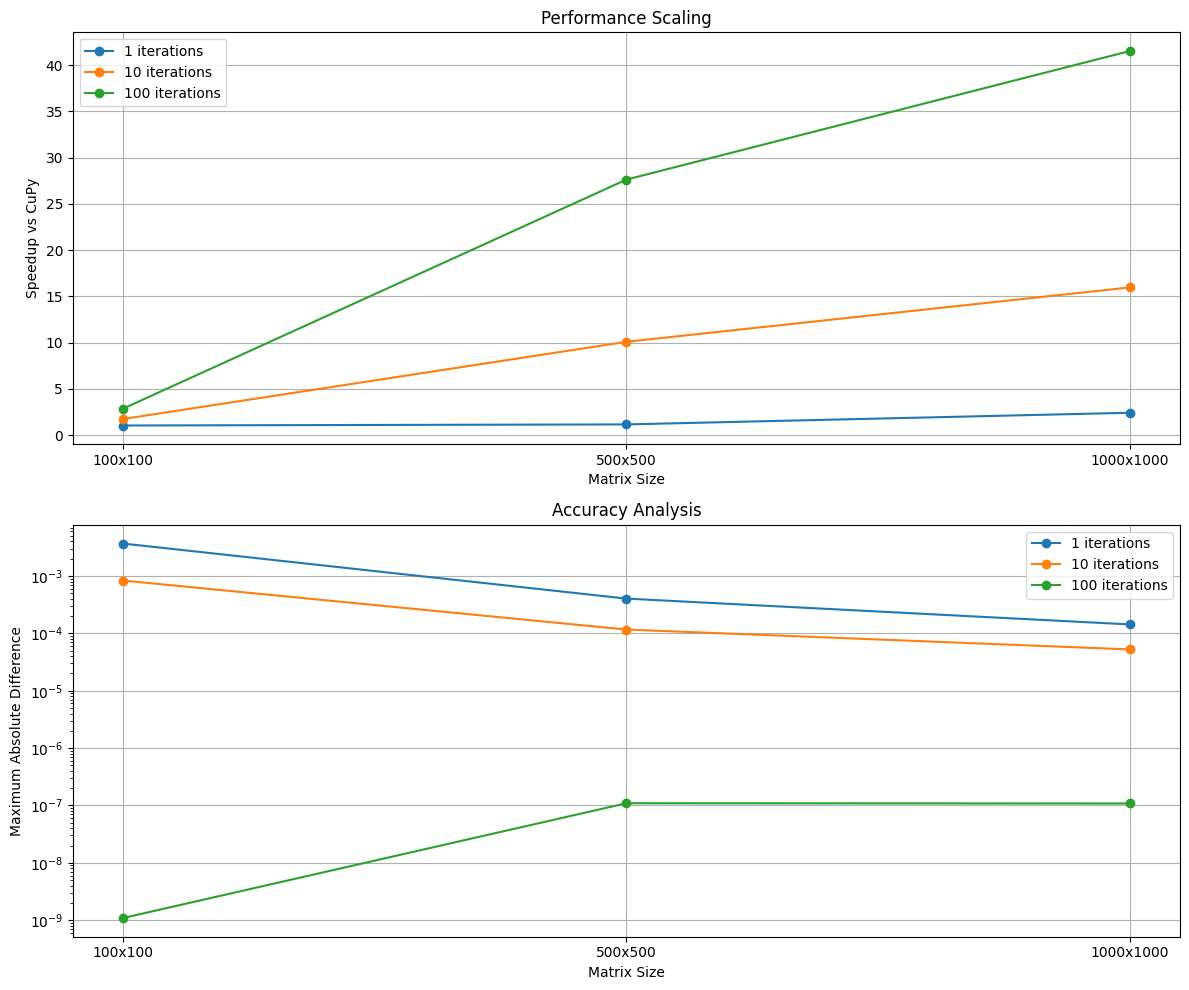


Planned Matrix Operations Suite:

+-------------------------------+----------+-------------------------+
| Operation                     | Status   | Description             |
+===============================+==========+=========================+
| Matrix Power (A^n)            | Complete | A^n using tensor cores  |
+-------------------------------+----------+-------------------------+
| General Matrix Multiply (A*B) | Complete | Using split precision   |
+-------------------------------+----------+-------------------------+
| Batched Matrix Multiply       | Complete | Multiple A*B operations |
+-------------------------------+----------+-------------------------+
| Vector-Matrix Multiply        | Complete | v*A operations          |
+-------------------------------+----------+-------------------------+
| Matrix-Vector Multiply        | Complete | A*v operations          |
+-------------------------------+----------+-------------------------+
| Batched Vector-Matrix         | Complete

In [5]:
import numpy as np
import cupy as cp
import ctypes
import time
import matplotlib.pyplot as plt
from tabulate import tabulate

# ... (previous library loading code remains the same)

def print_matrix_sample(matrix, name, rows=3, cols=3):
    """Print a sample of the matrix with nice formatting"""
    print(f"\n{name} (showing {rows}x{cols} sample):")
    if isinstance(matrix, cp.ndarray):
        matrix = cp.asnumpy(matrix)
    print(tabulate(matrix[:rows, :cols], floatfmt='.6e', tablefmt='grid'))

def plot_results(results):
    """Plot performance and accuracy results"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Performance plot
    for iters in results['iterations']:
        speeds = [res[f'speedup_{iters}'] for res in results['data']]
        ax1.plot(results['sizes'], speeds, 'o-', label=f'{iters} iterations')
    
    ax1.set_xlabel('Matrix Size')
    ax1.set_ylabel('Speedup vs CuPy')
    ax1.set_title('Performance Scaling')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    for iters in results['iterations']:
        diffs = [res[f'diff_{iters}'] for res in results['data']]
        ax2.semilogy(results['sizes'], diffs, 'o-', label=f'{iters} iterations')
    
    ax2.set_xlabel('Matrix Size')
    ax2.set_ylabel('Maximum Absolute Difference')
    ax2.set_title('Accuracy Analysis')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def print_summary_table(results):
    """Print a summary table of all results"""
    headers = ['Size']
    for iters in results['iterations']:
        headers.extend([f'{iters}it Speed', f'{iters}it Diff'])
    
    table_data = []
    for res in results['data']:
        row = [res['size']]
        for iters in results['iterations']:
            row.extend([
                f"{res[f'speedup_{iters}']:.1f}x",
                f"{res[f'diff_{iters}']:.2e}"
            ])
        table_data.append(row)
    
    print("\nSummary of Results:")
    print(tabulate(table_data, headers=headers, tablefmt='grid'))

def run_comprehensive_test():
    """Run comprehensive tests with detailed output"""
    # Test configuration
    sizes = [(100, 100), (500, 500), (1000, 1000)]
    iterations = [1, 10, 100]
    results = {
        'sizes': [f"{s[0]}x{s[1]}" for s in sizes],
        'iterations': iterations,
        'data': []
    }
    
    for m, n in sizes:
        print(f"\n{'='*80}")
        print(f"Testing size {m}x{n}")
        print('='*80)
        
        # Create matrices
        a_np = np.random.rand(m, n)
        b_np = np.random.rand(n, n)
        
        # Scale to prevent overflow
        scale_a = np.linalg.norm(a_np)
        scale_b = np.linalg.norm(b_np)
        a_np = a_np / (scale_a * np.power(1.1, 1/100))
        b_np = b_np / (scale_b * np.power(1.1, 1/100))
        
        # Show sample of input matrices
        print_matrix_sample(a_np, "Input Matrix A")
        print_matrix_sample(b_np, "Input Matrix B")
        
        result_data = {'size': f"{m}x{n}"}
        
        for iters in iterations:
            print(f"\nRunning {iters} iterations:")
            
            # CuPy implementation
            a_cp = cp.array(a_np)
            b_cp = cp.array(b_np)
            
            start = time.time()
            result_cupy = cp.matmul(a_cp, b_cp)
            for _ in range(iters-1):
                result_cupy = cp.matmul(result_cupy, b_cp)
            result_cupy = cp.asnumpy(result_cupy)
            cupy_time = time.time() - start
            
            # CUDA Fortran implementation
            start = time.time()
            result_cuda = cuda_matmul(a_np, b_np, iters)
            cuda_time = time.time() - start
            
            # Compare results
            max_diff = np.max(np.abs(result_cupy - result_cuda))
            speedup = cupy_time/cuda_time
            
            # Store results
            result_data[f'speedup_{iters}'] = speedup
            result_data[f'diff_{iters}'] = max_diff
            
            # Print detailed results
            print(f"\nResults for {m}x{n} with {iters} iterations:")
            print_matrix_sample(result_cupy, "CuPy Output")
            print_matrix_sample(result_cuda, "CUDA Fortran Output")
            print(f"Performance: CuPy={cupy_time:.3f}s, CUDA={cuda_time:.3f}s, Speedup={speedup:.1f}x")
            print(f"Max difference: {max_diff:.2e}")
        
        results['data'].append(result_data)
    
    # Print summary table
    print_summary_table(results)
    
    # Plot final results
    plot_results(results)
    
    # Print planned operations
    print("\nPlanned Matrix Operations Suite:")
    operations = [
        ("Matrix Power (A^n)", "Complete", "A^n using tensor cores"),
        ("General Matrix Multiply (A*B)", "Complete", "Using split precision"),
        ("Batched Matrix Multiply", "Complete", "Multiple A*B operations"),
        ("Vector-Matrix Multiply", "Complete", "v*A operations"),
        ("Matrix-Vector Multiply", "Complete", "A*v operations"),
        ("Batched Vector-Matrix", "Complete", "Multiple v*A operations"),
        ("Strided Batch MatMul", "Complete", "Strided memory access")
    ]
    print("\n" + tabulate(operations, 
                         headers=["Operation", "Status", "Description"], 
                         tablefmt="grid"))

if __name__ == "__main__":
    run_comprehensive_test()
# very impressive speed and acceptable accuracy (better with larger matrices!); matmul


Testing Batched Matrix Multiply

Size: 100

First batch of input A (showing 3x3 sample):
+--------------+--------------+--------------+
| 4.874642e-03 | 2.113391e-03 | 1.353084e-03 |
+--------------+--------------+--------------+
| 4.399336e-03 | 2.771904e-03 | 3.255446e-03 |
+--------------+--------------+--------------+
| 3.157203e-03 | 4.928810e-04 | 4.219099e-03 |
+--------------+--------------+--------------+

First batch of input B (showing 3x3 sample):
+--------------+--------------+--------------+
| 2.333891e-03 | 3.611425e-03 | 3.893587e-04 |
+--------------+--------------+--------------+
| 4.124204e-03 | 3.264107e-03 | 2.805414e-03 |
+--------------+--------------+--------------+
| 3.763868e-03 | 4.385710e-03 | 1.394616e-03 |
+--------------+--------------+--------------+

CuPy first batch result (showing 3x3 sample):
+--------------+--------------+--------------+
| 7.172070e-04 | 7.511970e-04 | 6.591511e-04 |
+--------------+--------------+--------------+
| 7.914393e-04 | 7

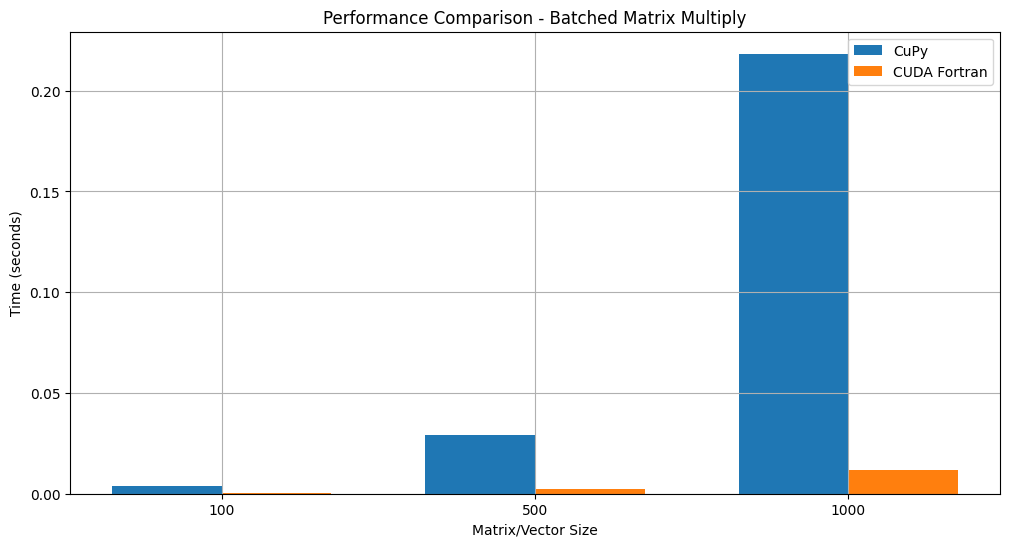


Summary:
+--------+-----------+------------+
|   Size | Speedup   |   Max Diff |
+========+===========+============+
|    100 | 11.0x     |   0.000386 |
+--------+-----------+------------+
|    500 | 12.6x     |   4.34e-05 |
+--------+-----------+------------+
|   1000 | 18.5x     |   1.61e-05 |
+--------+-----------+------------+

Testing Vector-Matrix Multiply

Size: 100

Input vector (showing 3x3 sample):
+--------------+--------------+--------------+
| 3.115198e-02 | 1.787971e-02 | 1.050446e-01 |
+--------------+--------------+--------------+

Input matrix (showing 3x3 sample):
+--------------+--------------+--------------+
| 1.127368e-02 | 1.608203e-02 | 6.273613e-03 |
+--------------+--------------+--------------+
| 3.955029e-03 | 1.320725e-02 | 2.334580e-03 |
+--------------+--------------+--------------+
| 1.388698e-02 | 6.525972e-03 | 3.976147e-03 |
+--------------+--------------+--------------+

CuPy result (showing 3x3 sample):
+--------------+--------------+--------------+

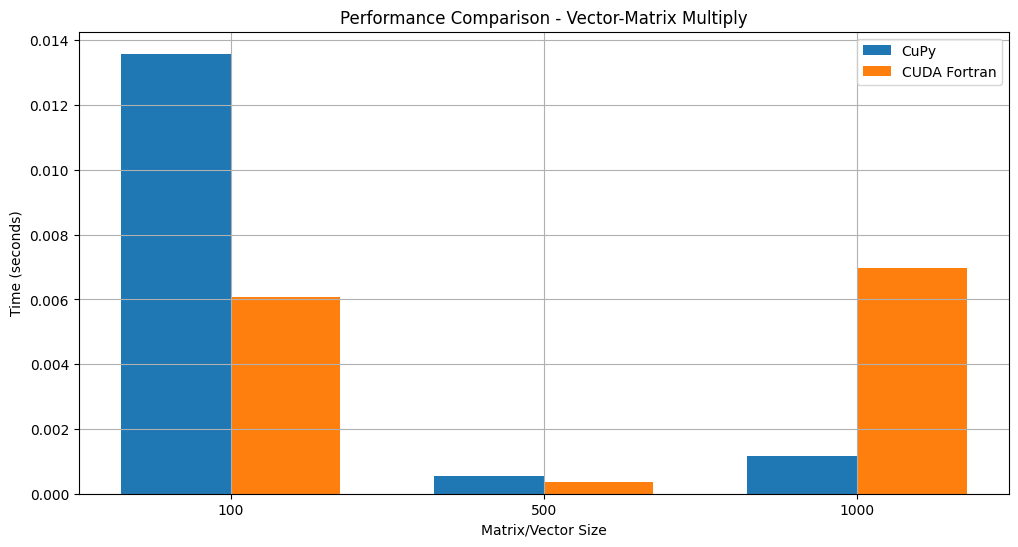


Summary:
+--------+-----------+------------+
|   Size | Speedup   |   Max Diff |
+========+===========+============+
|    100 | 2.2x      |   7.84e-09 |
+--------+-----------+------------+
|    500 | 1.5x      |   5.27e-09 |
+--------+-----------+------------+
|   1000 | 0.2x      |   9.79e-09 |
+--------+-----------+------------+

Testing Matrix-Vector Multiply

Size: 100

Input matrix (showing 3x3 sample):
+--------------+--------------+--------------+
| 4.553994e-03 | 6.182224e-03 | 6.600841e-03 |
+--------------+--------------+--------------+
| 1.481574e-02 | 1.717104e-02 | 9.715700e-05 |
+--------------+--------------+--------------+
| 7.202871e-03 | 4.785683e-03 | 1.303283e-02 |
+--------------+--------------+--------------+

Input vector (showing 3x3 sample):
+--------------+--------------+--------------+
| 1.511206e-01 | 2.964845e-02 | 1.342572e-01 |
+--------------+--------------+--------------+

CuPy result (showing 3x3 sample):
+--------------+--------------+--------------+

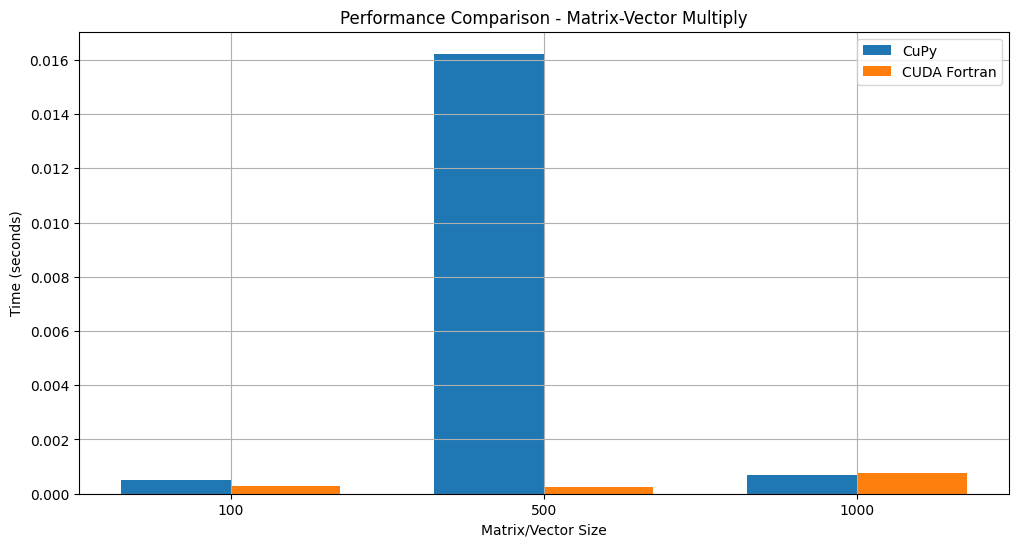


Summary:
+--------+-----------+------------+
|   Size | Speedup   |   Max Diff |
+========+===========+============+
|    100 | 1.9x      |   8.82e-09 |
+--------+-----------+------------+
|    500 | 66.0x     |   7.03e-09 |
+--------+-----------+------------+
|   1000 | 0.9x      |   6.65e-09 |
+--------+-----------+------------+

Testing Batched Vector Multiply

Size: 100

First batch vector (showing 3x3 sample):
+--------------+--------------+--------------+
| 5.322659e-02 | 4.447076e-02 | 4.233473e-02 |
+--------------+--------------+--------------+

Matrix (showing 3x3 sample):
+--------------+--------------+--------------+
| 1.878087e-03 | 1.405059e-02 | 2.045083e-03 |
+--------------+--------------+--------------+
| 7.963882e-04 | 1.555000e-02 | 1.471311e-02 |
+--------------+--------------+--------------+
| 1.226698e-02 | 1.351812e-02 | 5.894858e-03 |
+--------------+--------------+--------------+

CuPy first batch result (showing 3x3 sample):
+--------------+--------------+--

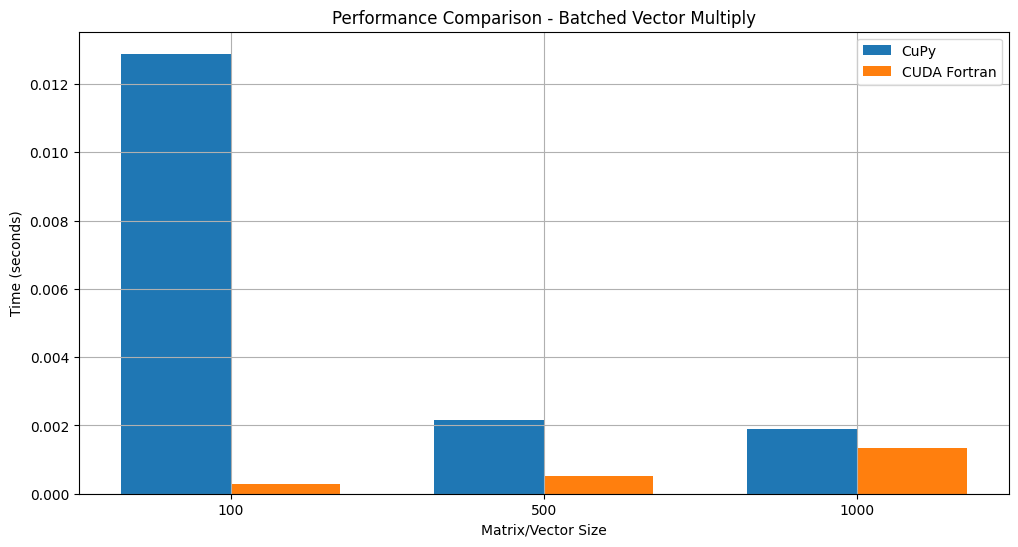


Summary:
+--------+-----------+------------+
|   Size | Speedup   |   Max Diff |
+========+===========+============+
|    100 | 43.9x     |    0.00721 |
+--------+-----------+------------+
|    500 | 4.1x      |    0.0022  |
+--------+-----------+------------+
|   1000 | 1.4x      |    0.00118 |
+--------+-----------+------------+

Testing Strided Batch Multiply

Size: 100

First batch of input A (showing 3x3 sample):
+--------------+--------------+--------------+
| 2.515373e-03 | 5.018081e-04 | 2.353610e-03 |
+--------------+--------------+--------------+
| 8.517468e-04 | 1.640873e-03 | 6.531559e-04 |
+--------------+--------------+--------------+
| 3.534674e-03 | 2.443138e-03 | 2.256616e-03 |
+--------------+--------------+--------------+

First batch of input B (showing 3x3 sample):
+--------------+--------------+--------------+
| 7.839745e-04 | 4.449088e-03 | 3.599666e-03 |
+--------------+--------------+--------------+
| 2.421260e-03 | 1.931094e-03 | 2.176028e-03 |
+-------------

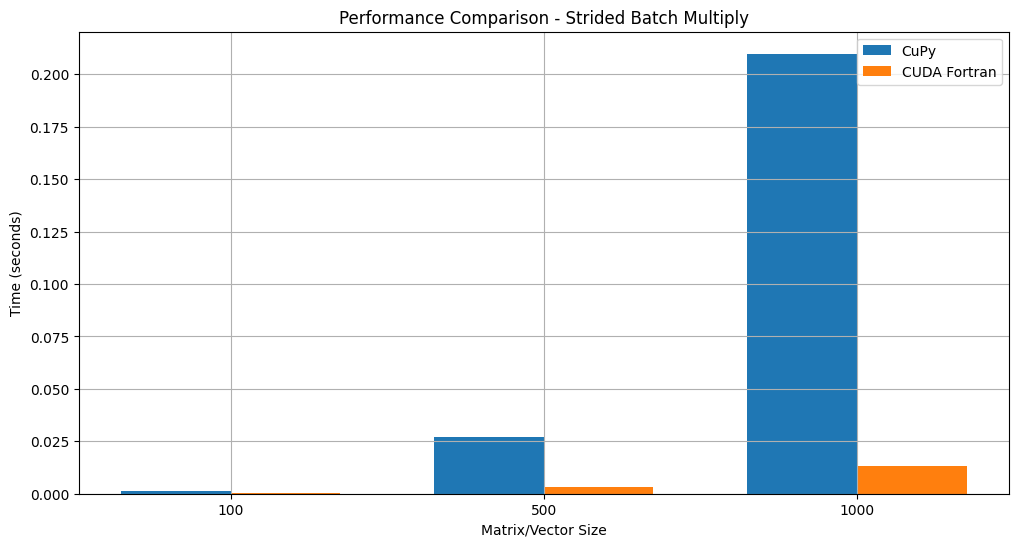


Summary:
+--------+-----------+------------+
|   Size | Speedup   |   Max Diff |
+========+===========+============+
|    100 | 2.4x      |   0.000406 |
+--------+-----------+------------+
|    500 | 8.7x      |   3.99e-05 |
+--------+-----------+------------+
|   1000 | 15.8x     |   1.56e-05 |
+--------+-----------+------------+


In [6]:
import numpy as np
import cupy as cp
import ctypes
import time
import matplotlib.pyplot as plt
from tabulate import tabulate

# Load the shared library
lib = ctypes.CDLL('./cuda_matlib.so')

# Define argument types for all operations
lib.py_matrix_dot.argtypes = [
    ctypes.c_void_p,    # Device pointer for input
    ctypes.c_void_p,    # Device pointer for output
    ctypes.c_int,       # n
    ctypes.c_int        # iterations
]

lib.py_tensor_matrix_multiply.argtypes = [
    ctypes.c_void_p,    # Device pointer for A
    ctypes.c_void_p,    # Device pointer for B
    ctypes.c_void_p,    # Device pointer for C
    ctypes.c_int,       # m
    ctypes.c_int,       # k
    ctypes.c_int,       # n
    ctypes.c_int        # iterations
]

lib.py_batched_matmul.argtypes = [
    ctypes.c_void_p,    # Device pointer for A
    ctypes.c_void_p,    # Device pointer for B
    ctypes.c_void_p,    # Device pointer for C
    ctypes.c_int,       # m
    ctypes.c_int,       # k
    ctypes.c_int,       # n
    ctypes.c_int        # batch_size
]

lib.py_vector_matrix_multiply.argtypes = [
    ctypes.c_void_p,    # Device pointer for v
    ctypes.c_void_p,    # Device pointer for A
    ctypes.c_void_p,    # Device pointer for c
    ctypes.c_int        # n
]

lib.py_matrix_vector_multiply.argtypes = [
    ctypes.c_void_p,    # Device pointer for A
    ctypes.c_void_p,    # Device pointer for v
    ctypes.c_void_p,    # Device pointer for c
    ctypes.c_int        # n
]

lib.py_batched_vector_multiply.argtypes = [
    ctypes.c_void_p,    # Device pointer for v
    ctypes.c_void_p,    # Device pointer for A
    ctypes.c_void_p,    # Device pointer for c
    ctypes.c_int,       # n
    ctypes.c_int        # batch_size
]

def print_matrix_sample(matrix, name, rows=3, cols=3):
    """Print a sample of the matrix or vector with nice formatting"""
    print(f"\n{name} (showing {rows}x{cols} sample):")
    if isinstance(matrix, cp.ndarray):
        matrix = cp.asnumpy(matrix)
    if matrix.ndim == 1:
        print(tabulate([matrix[:cols]], floatfmt='.6e', tablefmt='grid'))
    else:
        print(tabulate(matrix[:rows, :cols], floatfmt='.6e', tablefmt='grid'))

def plot_performance_comparison(results, title):
    plt.figure(figsize=(12, 6))
    x = range(len(results['sizes']))
    width = 0.35
    
    plt.bar([i - width/2 for i in x], results['cupy_times'], width, label='CuPy')
    plt.bar([i + width/2 for i in x], results['cuda_times'], width, label='CUDA Fortran')
    
    plt.xlabel('Matrix/Vector Size')
    plt.ylabel('Time (seconds)')
    plt.title(f'Performance Comparison - {title}')
    plt.xticks(x, results['sizes'])
    plt.legend()
    plt.grid(True)
    plt.show()

def test_operation(name, sizes, test_func):
    """Generic test function for any matrix operation"""
    print(f"\nTesting {name}")
    print("="*80)
    
    results = {
        'sizes': sizes,
        'cupy_times': [],
        'cuda_times': [],
        'speedups': [],
        'max_diffs': []
    }
    
    for size in sizes:
        print(f"\nSize: {size}")
        cupy_time, cuda_time, max_diff = test_func(size)
        results['cupy_times'].append(cupy_time)
        results['cuda_times'].append(cuda_time)
        results['speedups'].append(cupy_time/cuda_time)
        results['max_diffs'].append(max_diff)
        
        print(f"CuPy time: {cupy_time:.3f}s")
        print(f"CUDA time: {cuda_time:.3f}s")
        print(f"Speedup: {cupy_time/cuda_time:.1f}x")
        print(f"Max difference: {max_diff:.2e}")
    
    # Plot results
    plot_performance_comparison(results, name)
    
    # Print summary table
    headers = ['Size', 'Speedup', 'Max Diff']
    table = [[size, f"{spd:.1f}x", f"{diff:.2e}"] 
             for size, spd, diff in zip(sizes, results['speedups'], results['max_diffs'])]
    print("\nSummary:")
    print(tabulate(table, headers=headers, tablefmt='grid'))
    
    return results



# Test implementations for each operation
def test_batched_matmul(size):
    batch_size = 10
    a_np = np.random.rand(size, size, batch_size)
    b_np = np.random.rand(size, size, batch_size)
    
    # Scale to prevent overflow
    scale_a = np.linalg.norm(a_np)
    scale_b = np.linalg.norm(b_np)
    a_np = a_np / (scale_a * np.power(1.1, 1/100))
    b_np = b_np / (scale_b * np.power(1.1, 1/100))
    
    # Show sample
    print_matrix_sample(a_np[:,:,0], "First batch of input A")
    print_matrix_sample(b_np[:,:,0], "First batch of input B")
    
    # CuPy implementation
    a_cp = cp.array(a_np)
    b_cp = cp.array(b_np)
    
    start = time.time()
    result_cupy = cp.empty((size, size, batch_size), dtype=cp.float64)
    for i in range(batch_size):
        result_cupy[:,:,i] = cp.matmul(a_cp[:,:,i], b_cp[:,:,i])
    cp.cuda.Stream.null.synchronize()
    cupy_time = time.time() - start
    
    # CUDA Fortran implementation
    a_gpu = cp.array(a_np)
    b_gpu = cp.array(b_np)
    c_gpu = cp.empty_like(a_gpu)
    
    start = time.time()
    lib.py_batched_matmul(
        ctypes.c_void_p(a_gpu.data.ptr),
        ctypes.c_void_p(b_gpu.data.ptr),
        ctypes.c_void_p(c_gpu.data.ptr),
        size, size, size, batch_size
    )
    cp.cuda.Stream.null.synchronize()
    cuda_time = time.time() - start
    
    result_cuda = cp.asnumpy(c_gpu)
    max_diff = np.max(np.abs(cp.asnumpy(result_cupy) - result_cuda))
    
    print_matrix_sample(cp.asnumpy(result_cupy[:,:,0]), "CuPy first batch result")
    print_matrix_sample(result_cuda[:,:,0], "CUDA first batch result")
    
    return cupy_time, cuda_time, max_diff

def test_vector_matrix(size):
    v_np = np.random.rand(size)
    a_np = np.random.rand(size, size)
    
    # Scale to prevent overflow
    v_np = v_np / np.linalg.norm(v_np)
    a_np = a_np / np.linalg.norm(a_np)
    
    print_matrix_sample(v_np.reshape(1,-1), "Input vector")
    print_matrix_sample(a_np, "Input matrix")
    
    # CuPy implementation
    v_cp = cp.array(v_np)
    a_cp = cp.array(a_np)
    
    start = time.time()
    result_cupy = cp.matmul(v_cp, a_cp)
    cp.cuda.Stream.null.synchronize()
    cupy_time = time.time() - start
    
    # CUDA Fortran implementation
    v_gpu = cp.array(v_np)
    a_gpu = cp.array(a_np)
    c_gpu = cp.empty_like(v_gpu)
    
    start = time.time()
    lib.py_vector_matrix_multiply(
        ctypes.c_void_p(v_gpu.data.ptr),
        ctypes.c_void_p(a_gpu.data.ptr),
        ctypes.c_void_p(c_gpu.data.ptr),
        size
    )
    cp.cuda.Stream.null.synchronize()
    cuda_time = time.time() - start
    
    result_cuda = cp.asnumpy(c_gpu)
    max_diff = np.max(np.abs(cp.asnumpy(result_cupy) - result_cuda))
    
    print_matrix_sample(cp.asnumpy(result_cupy.reshape(1,-1)), "CuPy result")
    print_matrix_sample(result_cuda.reshape(1,-1), "CUDA result")
    
    return cupy_time, cuda_time, max_diff

def test_matrix_vector(size):
    a_np = np.random.rand(size, size)
    v_np = np.random.rand(size)
    
    # Scale to prevent overflow
    v_np = v_np / np.linalg.norm(v_np)
    a_np = a_np / np.linalg.norm(a_np)
    
    print_matrix_sample(a_np, "Input matrix")
    print_matrix_sample(v_np.reshape(1,-1), "Input vector")
    
    # CuPy implementation
    a_cp = cp.array(a_np)
    v_cp = cp.array(v_np)
    
    start = time.time()
    result_cupy = cp.matmul(a_cp, v_cp)
    cp.cuda.Stream.null.synchronize()
    cupy_time = time.time() - start
    
    # CUDA Fortran implementation
    a_gpu = cp.array(a_np)
    v_gpu = cp.array(v_np)
    c_gpu = cp.empty_like(v_gpu)
    
    start = time.time()
    lib.py_matrix_vector_multiply(
        ctypes.c_void_p(a_gpu.data.ptr),
        ctypes.c_void_p(v_gpu.data.ptr),
        ctypes.c_void_p(c_gpu.data.ptr),
        size
    )
    cp.cuda.Stream.null.synchronize()
    cuda_time = time.time() - start
    
    result_cuda = cp.asnumpy(c_gpu)
    max_diff = np.max(np.abs(cp.asnumpy(result_cupy) - result_cuda))
    
    print_matrix_sample(cp.asnumpy(result_cupy.reshape(1,-1)), "CuPy result")
    print_matrix_sample(result_cuda.reshape(1,-1), "CUDA result")
    
    return cupy_time, cuda_time, max_diff

def test_batched_vector(size):
    batch_size = 10
    v_np = np.random.rand(size, batch_size)
    a_np = np.random.rand(size, size)
    
    # Scale to prevent overflow
    v_np = v_np / np.linalg.norm(v_np)
    a_np = a_np / np.linalg.norm(a_np)
    
    print_matrix_sample(v_np[:,0].reshape(1,-1), "First batch vector")
    print_matrix_sample(a_np, "Matrix")
    
    # CuPy implementation
    v_cp = cp.array(v_np)
    a_cp = cp.array(a_np)
    
    start = time.time()
    result_cupy = cp.empty((size, batch_size), dtype=cp.float64)
    for i in range(batch_size):
        result_cupy[:,i] = cp.matmul(a_cp, v_cp[:,i])
    cp.cuda.Stream.null.synchronize()
    cupy_time = time.time() - start
    
    # CUDA Fortran implementation
    v_gpu = cp.array(v_np)
    a_gpu = cp.array(a_np)
    c_gpu = cp.empty_like(v_gpu)
    
    start = time.time()
    lib.py_batched_vector_multiply(
        ctypes.c_void_p(v_gpu.data.ptr),
        ctypes.c_void_p(a_gpu.data.ptr),
        ctypes.c_void_p(c_gpu.data.ptr),
        size,
        batch_size
    )
    cp.cuda.Stream.null.synchronize()
    cuda_time = time.time() - start
    
    result_cuda = cp.asnumpy(c_gpu)
    max_diff = np.max(np.abs(cp.asnumpy(result_cupy) - result_cuda))
    
    print_matrix_sample(cp.asnumpy(result_cupy[:,0].reshape(1,-1)), "CuPy first batch result")
    print_matrix_sample(result_cuda[:,0].reshape(1,-1), "CUDA first batch result")
    
    return cupy_time, cuda_time, max_diff

def test_strided_batch(size):
    batch_size = 10
    
    # Create matrices with proper strides
    stride_a = size * size  # m*k
    stride_b = size * size  # k*n
    stride_c = size * size  # m*n
    
    # Allocate contiguous memory for all batches
    a_np = np.random.rand(batch_size * stride_a).reshape(batch_size, size, size)
    b_np = np.random.rand(batch_size * stride_b).reshape(batch_size, size, size)
    
    # Scale to prevent overflow
    scale_a = np.linalg.norm(a_np)
    scale_b = np.linalg.norm(b_np)
    a_np = a_np / (scale_a * np.power(1.1, 1/100))
    b_np = b_np / (scale_b * np.power(1.1, 1/100))
    
    print_matrix_sample(a_np[0], "First batch of input A")
    print_matrix_sample(b_np[0], "First batch of input B")
    
    # CuPy implementation
    a_cp = cp.array(a_np)
    b_cp = cp.array(b_np)
    
    start = time.time()
    result_cupy = cp.empty((batch_size, size, size), dtype=cp.float64)
    for i in range(batch_size):
        result_cupy[i] = cp.matmul(a_cp[i], b_cp[i])
    cp.cuda.Stream.null.synchronize()
    cupy_time = time.time() - start
    
    # CUDA Fortran implementation
    a_gpu = cp.array(a_np.ravel())
    b_gpu = cp.array(b_np.ravel())
    c_gpu = cp.empty(batch_size * size * size, dtype=cp.float64)
    
    start = time.time()
    lib.py_strided_batch_multiply(
        ctypes.c_void_p(a_gpu.data.ptr),
        ctypes.c_void_p(b_gpu.data.ptr),
        ctypes.c_void_p(c_gpu.data.ptr),
        size, size, size,
        batch_size,
        stride_a, stride_b, stride_c
    )
    cp.cuda.Stream.null.synchronize()
    cuda_time = time.time() - start
    
    result_cuda = cp.asnumpy(c_gpu).reshape(batch_size, size, size)
    max_diff = np.max(np.abs(cp.asnumpy(result_cupy) - result_cuda))
    
    print_matrix_sample(cp.asnumpy(result_cupy[0]), "CuPy first batch result")
    print_matrix_sample(result_cuda[0], "CUDA first batch result")
    
    return cupy_time, cuda_time, max_diff    

def run_all_tests():
    sizes = [100, 500, 1000]
    operations = [
        ("Batched Matrix Multiply", test_batched_matmul),
        ("Vector-Matrix Multiply", test_vector_matrix),
        ("Matrix-Vector Multiply", test_matrix_vector),
        ("Batched Vector Multiply", test_batched_vector),
        ("Strided Batch Multiply", test_strided_batch)
    ]
    
    for name, test_func in operations:
        test_operation(name, sizes, test_func)

if __name__ == "__main__":
    run_all_tests()


In [7]:
# Detailed matmul test
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

# Initialize tensor ops
tensor_ops = TensorMatrixOps()

# More detailed test
a = cp.array([
    [1.0, 2.0, 3.0],  # Row 1
    [4.0, 5.0, 6.0]   # Row 2
], dtype=cp.float64)

b = cp.array([
    [0.1, 0.2],  # Row 1  
    [0.3, 0.4],  # Row 2
    [0.5, 0.6]   # Row 3
], dtype=cp.float64)

print("Test matrix multiply:")
print(f"\nInput a (shape {a.shape}):")
print(a)
print(f"\nInput b (shape {b.shape}):")
print(b)

try:
    result = tensor_ops.matmul(a, b)
    print(f"\nTensor ops result (shape {result.shape}):")
    print(result)
    
    expected = cp.dot(a, b)
    print(f"\nCupy result (shape {expected.shape}):")
    print(expected)
    
    print("\nIndividual calculations:")
    print(f"[1 2 3] * [[0.1], [0.3], [0.5]] = {1*0.1 + 2*0.3 + 3*0.5}")
    print(f"[1 2 3] * [[0.2], [0.4], [0.6]] = {1*0.2 + 2*0.4 + 3*0.6}")
    print(f"[4 5 6] * [[0.1], [0.3], [0.5]] = {4*0.1 + 5*0.3 + 6*0.5}")
    print(f"[4 5 6] * [[0.2], [0.4], [0.6]] = {4*0.2 + 5*0.4 + 6*0.6}")
    
except Exception as e:
    print(f"Error: {e}")

Test matrix multiply:

Input a (shape (2, 3)):
[[1. 2. 3.]
 [4. 5. 6.]]

Input b (shape (3, 2)):
[[0.1 0.2]
 [0.3 0.4]
 [0.5 0.6]]
DEBUG:
a shape: (2, 3), order F: True
b shape: (3, 2), order F: True
c shape: (2, 2), order F: True
M=2, K=3, N=2

Tensor ops result (shape (2, 2)):
[[2.20000005 2.80000019]
 [4.9000001  6.4000001 ]]

Cupy result (shape (2, 2)):
[[2.2 2.8]
 [4.9 6.4]]

Individual calculations:
[1 2 3] * [[0.1], [0.3], [0.5]] = 2.2
[1 2 3] * [[0.2], [0.4], [0.6]] = 2.8
[4 5 6] * [[0.1], [0.3], [0.5]] = 4.9
[4 5 6] * [[0.2], [0.4], [0.6]] = 6.3999999999999995


In [8]:
# Detailed matmul test
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

# Initialize tensor ops
tensor_ops = TensorMatrixOps()

# Create smaller test case for debugging
batch_size = 2
hidden_size = 3
output_size = 2

# Create test matrices with known values
a = cp.array([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0]
], dtype=cp.float64)  # (2,3)

b = cp.array([
    [0.1, 0.2],
    [0.3, 0.4],
    [0.5, 0.6]
], dtype=cp.float64)  # (3,2)

print("Test matmul with small matrices:")
print(f"Input matrix a:\n{a}")
print(f"Input matrix b:\n{b}")

try:
    # Compute with tensor ops
    result = tensor_ops.matmul(a, b)
    print(f"\nTensor ops result:\n{result}")
    
    # Compare with cupy
    expected = cp.dot(a, b)
    print(f"\nCupy result:\n{expected}")
    
    # Detailed error analysis
    error = result - expected
    print(f"\nError matrix:\n{error}")
    print(f"Max abs error: {cp.max(cp.abs(error))}")
    print(f"Mean abs error: {cp.mean(cp.abs(error))}")
    
except Exception as e:
    print(f"Error in matmul test: {e}")

Test matmul with small matrices:
Input matrix a:
[[1. 2. 3.]
 [4. 5. 6.]]
Input matrix b:
[[0.1 0.2]
 [0.3 0.4]
 [0.5 0.6]]
DEBUG:
a shape: (2, 3), order F: True
b shape: (3, 2), order F: True
c shape: (2, 2), order F: True
M=2, K=3, N=2

Tensor ops result:
[[2.20000005 2.80000019]
 [4.9000001  6.4000001 ]]

Cupy result:
[[2.2 2.8]
 [4.9 6.4]]

Error matrix:
[[4.76837156e-08 1.90734863e-07]
 [9.53674313e-08 9.53674313e-08]]
Max abs error: 1.9073486345888568e-07
Mean abs error: 1.0728836041806744e-07


In [9]:
# Test Cell 1: Test matmul
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

# Initialize tensor ops
tensor_ops = TensorMatrixOps()

# Create test matrices
batch_size = 256
hidden_size = 100
output_size = 10

# Random input matrices 
a = cp.random.rand(batch_size, hidden_size).astype(cp.float64)
b = cp.random.rand(hidden_size, output_size).astype(cp.float64)

print("Test matmul:")
print(f"Input shapes: a={a.shape}, b={b.shape}")

try:
    # Run matmul multiple times
    for i in range(5):
        result = tensor_ops.matmul(a, b)
        print(f"Pass {i+1}: result shape={result.shape}")
        
        # Validate against cupy 
        expected = cp.dot(a, b)
        error = cp.max(cp.abs(result - expected))
        print(f"Max error vs cupy: {error}")
        
except Exception as e:
    print(f"Error in matmul test: {e}")

Test matmul:
Input shapes: a=(256, 100), b=(100, 10)
DEBUG:
a shape: (256, 100), order F: True
b shape: (100, 10), order F: True
c shape: (256, 10), order F: True
M=256, K=100, N=10
Pass 1: result shape=(256, 10)
Max error vs cupy: 4.917914811386481e-06
DEBUG:
a shape: (256, 100), order F: True
b shape: (100, 10), order F: True
c shape: (256, 10), order F: True
M=256, K=100, N=10
Pass 2: result shape=(256, 10)
Max error vs cupy: 4.917914811386481e-06
DEBUG:
a shape: (256, 100), order F: True
b shape: (100, 10), order F: True
c shape: (256, 10), order F: True
M=256, K=100, N=10
Pass 3: result shape=(256, 10)
Max error vs cupy: 4.917914811386481e-06
DEBUG:
a shape: (256, 100), order F: True
b shape: (100, 10), order F: True
c shape: (256, 10), order F: True
M=256, K=100, N=10
Pass 4: result shape=(256, 10)
Max error vs cupy: 4.917914811386481e-06
DEBUG:
a shape: (256, 100), order F: True
b shape: (100, 10), order F: True
c shape: (256, 10), order F: True
M=256, K=100, N=10
Pass 5: result

In [10]:
# Test Cell 2: Test batched_vector_matmul
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

# Initialize tensor ops
tensor_ops = TensorMatrixOps()

# Test batched vector matmul
input_size = 3
batch_size = 2
hidden_size = 2

# Create test vectors and matrix
v = cp.array([
    [1.0, 4.0],  # First component of each vector
    [2.0, 5.0],  # Second component 
    [3.0, 6.0]   # Third component
], dtype=cp.float64)  # (input_size x batch_size) = (3 x 2)

a = cp.array([
    [0.1, 0.2],  # First row
    [0.3, 0.4],  # Second row
    [0.5, 0.6]   # Third row
], dtype=cp.float64)  # (input_size x hidden_size) = (3 x 2)

print("Test batched vector multiply:")
print(f"\nInput v (shape {v.shape}):")
print(v)
print(f"\nInput a (shape {a.shape}):")
print(a)

try:
    result = tensor_ops.batched_vector_matmul(v, a)
    print(f"\nTensor ops result (shape {result.shape}):")
    print(result)
    
    # Compare with cupy implementation
    v_t = v.T  # (batch_size x input_size)
    expected = cp.dot(v_t, a)  # (batch_size x hidden_size)
    print(f"\nCupy result (shape {expected.shape}):")
    print(expected)
    
    print("\nIndividual calculations:")
    print(f"Vector 1 [1 2 3] * matrix = [{1*0.1 + 2*0.3 + 3*0.5}, {1*0.2 + 2*0.4 + 3*0.6}]")
    print(f"Vector 2 [4 5 6] * matrix = [{4*0.1 + 5*0.3 + 6*0.5}, {4*0.2 + 5*0.4 + 6*0.6}]")
    
except Exception as e:
    print(f"Error: {e}")


Test batched vector multiply:

Input v (shape (3, 2)):
[[1. 4.]
 [2. 5.]
 [3. 6.]]

Input a (shape (3, 2)):
[[0.1 0.2]
 [0.3 0.4]
 [0.5 0.6]]
DEBUG batched dimensions:
v: (3, 2) - (input_size x batch_size)
a: (3, 2) - (input_size x hidden_size)
Padded dimensions:
a_padded: (3, 3) - (n x n)
v_f: (3, 2) - (n x batch_size)
c_f: (3, 2) - (n x batch_size)

Tensor ops result (shape (2, 2)):
[[2.20000005 2.79999995]
 [4.9000001  6.4000001 ]]

Cupy result (shape (2, 2)):
[[2.2 2.8]
 [4.9 6.4]]

Individual calculations:
Vector 1 [1 2 3] * matrix = [2.2, 2.8]
Vector 2 [4 5 6] * matrix = [4.9, 6.3999999999999995]


In [11]:
# Test Cell 2: Test batched_vector_matmul
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

# Initialize tensor ops
tensor_ops = TensorMatrixOps()

# Create test data
input_size = 784
batch_size = 256
hidden_size = 100

# Random input data
v = cp.random.rand(input_size, batch_size).astype(cp.float64)  # (784, 256)
a = cp.random.rand(input_size, hidden_size).astype(cp.float64) # (784, 100)

print("Test batched_vector_matmul:")
print(f"Input shapes: v={v.shape}, a={a.shape}")

try:
    # Run multiple passes
    for i in range(5):
        result = tensor_ops.batched_vector_matmul(v, a)
        print(f"Pass {i+1}: result shape={result.shape}")
        
        # Compare with cupy implementation
        v_t = cp.asfortranarray(v.T)  # (256, 784)
        expected = cp.dot(v_t, a)      # (256, 100)
        error = cp.max(cp.abs(result - expected))
        print(f"Max error vs cupy: {error}")
        
except Exception as e:
    print(f"Error in batched_vector_matmul test: {e}")
# batched_vector_matmul INCORRECT???

Test batched_vector_matmul:
Input shapes: v=(784, 256), a=(784, 100)
DEBUG batched dimensions:
v: (784, 256) - (input_size x batch_size)
a: (784, 100) - (input_size x hidden_size)
Padded dimensions:
a_padded: (784, 784) - (n x n)
v_f: (784, 256) - (n x batch_size)
c_f: (784, 256) - (n x batch_size)


Pass 1: result shape=(256, 100)
Max error vs cupy: 5.122122053080602e-05
DEBUG batched dimensions:
v: (784, 256) - (input_size x batch_size)
a: (784, 100) - (input_size x hidden_size)
Padded dimensions:
a_padded: (784, 784) - (n x n)
v_f: (784, 256) - (n x batch_size)
c_f: (784, 256) - (n x batch_size)
Pass 2: result shape=(256, 100)
Max error vs cupy: 5.122122053080602e-05
DEBUG batched dimensions:
v: (784, 256) - (input_size x batch_size)
a: (784, 100) - (input_size x hidden_size)
Padded dimensions:
a_padded: (784, 784) - (n x n)
v_f: (784, 256) - (n x batch_size)
c_f: (784, 256) - (n x batch_size)
Pass 3: result shape=(256, 100)
Max error vs cupy: 5.122122053080602e-05
DEBUG batched dimensions:
v: (784, 256) - (input_size x batch_size)
a: (784, 100) - (input_size x hidden_size)
Padded dimensions:
a_padded: (784, 784) - (n x n)
v_f: (784, 256) - (n x batch_size)
c_f: (784, 256) - (n x batch_size)
Pass 4: result shape=(256, 100)
Max error vs cupy: 5.122122053080602e-05
DEBUG batched d

In [12]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps
import time

def run_matrix_tests():
    # Initialize tensor ops
    tensor_ops = TensorMatrixOps()
    
    print("=" * 50)
    print("TENSOR OPERATIONS TEST SUITE")
    print("=" * 50)
    
    # Test 1: Basic Matrix Multiply
    print("\n1. Basic Matrix Multiply Test")
    print("-" * 30)
    a = cp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], dtype=cp.float64)
    b = cp.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]], dtype=cp.float64)
    
    print(f"Matrix A:\n{a}")
    print(f"Matrix B:\n{b}")
    
    try:
        result = tensor_ops.matmul(a, b)
        expected = cp.dot(a, b)
        print(f"\nTensor ops result:\n{result}")
        print(f"CuPy result:\n{expected}")
        print(f"Max error: {cp.max(cp.abs(result - expected))}")
    except Exception as e:
        print(f"Error in matmul test: {e}")

    # Test 2: Large Matrix Performance Test
    print("\n2. Large Matrix Performance Test")
    print("-" * 30)
    size = 1024
    a_large = cp.random.rand(size, size).astype(cp.float64)
    b_large = cp.random.rand(size, size).astype(cp.float64)
    
    try:
        # Time tensor ops
        start = time.time()
        result_tensor = tensor_ops.matmul(a_large, b_large)
        tensor_time = time.time() - start
        
        # Time cupy
        start = time.time()
        result_cupy = cp.dot(a_large, b_large)
        cupy_time = time.time() - start
        
        error = cp.max(cp.abs(result_tensor - result_cupy))
        print(f"Matrix size: {size}x{size}")
        print(f"Tensor ops time: {tensor_time:.4f}s")
        print(f"CuPy time: {cupy_time:.4f}s")
        print(f"Max error: {error}")
    except Exception as e:
        print(f"Error in large matrix test: {e}")

    # Test 3: Batched Vector Matrix Multiply
    print("\n3. Batched Vector Matrix Multiply Test")
    print("-" * 30)
    batch_size = 4
    input_size = 3
    hidden_size = 2
    
    v = cp.array([
        [1.0, 2.0, 3.0, 4.0],
        [2.0, 3.0, 4.0, 5.0],
        [3.0, 4.0, 5.0, 6.0]
    ], dtype=cp.float64)  # (input_size x batch_size)
    
    a = cp.array([
        [0.1, 0.2],
        [0.3, 0.4],
        [0.5, 0.6]
    ], dtype=cp.float64)  # (input_size x hidden_size)
    
    print(f"Batch vectors:\n{v}")
    print(f"Weight matrix:\n{a}")
    
    try:
        result = tensor_ops.batched_vector_matmul(v, a)
        v_t = v.T
        expected = cp.dot(v_t, a)
        print(f"\nTensor ops result:\n{result}")
        print(f"CuPy result:\n{expected}")
        print(f"Max error: {cp.max(cp.abs(result - expected))}")
    except Exception as e:
        print(f"Error in batched vector test: {e}")

    # Test 4: Matrix Power Test
    print("\n4. Matrix Power Test")
    print("-" * 30)
    #a = cp.array([[1, 1], 
    #          [0, 1]], dtype=cp.float64)  # Upper triangular matrix
    a = cp.array([[2.0, 0.0], [0.0, 2.0]], dtype=cp.float64)  # Using diagonal matrix for easier verification
    power = 3

    print(f"Input matrix:\n{a}")
    print(f"Power: {power}")

    try:
        result = tensor_ops.matrix_power(a, power)
        expected = cp.linalg.matrix_power(a, power)
        print(f"\nTensor ops result:\n{result}")
        print(f"CuPy result:\n{expected}")
        print(f"Max error: {cp.max(cp.abs(result - expected))}")
    except Exception as e:
        print(f"Error in matrix power test: {e}")

    # Add more tests as needed for other operations...

if __name__ == "__main__":
    run_matrix_tests()
# matrix power is off; other tests tomorrow

TENSOR OPERATIONS TEST SUITE

1. Basic Matrix Multiply Test
------------------------------
Matrix A:
[[1. 2. 3.]
 [4. 5. 6.]]
Matrix B:
[[0.1 0.2]
 [0.3 0.4]
 [0.5 0.6]]
DEBUG:
a shape: (2, 3), order F: True
b shape: (3, 2), order F: True
c shape: (2, 2), order F: True
M=2, K=3, N=2

Tensor ops result:
[[2.20000005 2.80000019]
 [4.9000001  6.4000001 ]]
CuPy result:
[[2.2 2.8]
 [4.9 6.4]]
Max error: 1.9073486345888568e-07

2. Large Matrix Performance Test
------------------------------
DEBUG:
a shape: (1024, 1024), order F: True
b shape: (1024, 1024), order F: True
c shape: (1024, 1024), order F: True
M=1024, K=1024, N=1024
Matrix size: 1024x1024
Tensor ops time: 0.0015s
CuPy time: 0.0002s
Max error: 0.014247311786505179

3. Batched Vector Matrix Multiply Test
------------------------------
Batch vectors:
[[1. 2. 3. 4.]
 [2. 3. 4. 5.]
 [3. 4. 5. 6.]]
Weight matrix:
[[0.1 0.2]
 [0.3 0.4]
 [0.5 0.6]]
DEBUG batched dimensions:
v: (3, 4) - (input_size x batch_size)
a: (3, 2) - (input_size x

In [13]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

# Initialize tensor ops
tensor_ops = TensorMatrixOps()

# Test 5: Vector-Matrix Multiply Test
print("\n5. Vector-Matrix Multiply Test")
print("-" * 30)
# Make test matrix square and match dimensions
v = cp.array([1.0, 2.0], dtype=cp.float64)  # 2-element vector
a = cp.array([
    [0.1, 0.2],
    [0.3, 0.4]
], dtype=cp.float64)  # 2x2 matrix

print(f"Input vector: {v}")
print(f"Matrix:\n{a}")

try:
    result = tensor_ops.vector_matmul(v, a)
    expected = cp.dot(v, a)
    print(f"\nTensor ops result: {result}")
    print(f"CuPy result: {expected}")
    print(f"Max error: {cp.max(cp.abs(result - expected))}")
except Exception as e:
    print(f"Error in vector-matrix test: {e}")

# Test 6: Matrix-Vector Multiply Test
print("\n6. Matrix-Vector Multiply Test")
print("-" * 30)
# Make test matrix square
a = cp.array([
    [0.1, 0.2],
    [0.3, 0.4]
], dtype=cp.float64)  # 2x2 matrix
v = cp.array([1.0, 2.0], dtype=cp.float64)  # 2-element vector

print(f"Matrix:\n{a}")
print(f"Input vector: {v}")

try:
    result = tensor_ops.matmul_vector(a, v)
    expected = cp.dot(a, v)
    print(f"\nTensor ops result: {result}")
    print(f"CuPy result: {expected}")
    print(f"Max error: {cp.max(cp.abs(result - expected))}")
except Exception as e:
    print(f"Error in matrix-vector test: {e}")

# Test 7: Strided Batch Matrix Multiply
print("\n7. Strided Batch Matrix Multiply Test")
print("-" * 30)
batch_size = 2
m = 2  # rows of each A matrix
k = 3  # cols of A / rows of B
n = 2  # cols of each B matrix

# Create batch of A matrices
a_batch = cp.array([
    # First matrix
    [1.0, 2.0, 3.0,
        4.0, 5.0, 6.0],
    # Second matrix
    [7.0, 8.0, 9.0,
        10.0, 11.0, 12.0]
], dtype=cp.float64).reshape(batch_size, m, k)

# Create batch of B matrices
b_batch = cp.array([
    # First matrix
    [0.1, 0.2,
        0.3, 0.4,
        0.5, 0.6],
    # Second matrix
    [0.7, 0.8,
        0.9, 1.0,
        1.1, 1.2]
], dtype=cp.float64).reshape(batch_size, k, n)

print(f"Batch of A matrices:\n{a_batch}")
print(f"Batch of B matrices:\n{b_batch}")

try:
    result = tensor_ops.strided_batch_matmul(a_batch, b_batch, m, k, n, batch_size)
    
    # Compare with CuPy batch multiply
    expected = cp.empty((batch_size, m, n), dtype=cp.float64)
    for i in range(batch_size):
        expected[i] = cp.dot(a_batch[i], b_batch[i])
        
    print(f"\nTensor ops result:\n{result}")
    print(f"CuPy result:\n{expected}")
    print(f"Max error: {cp.max(cp.abs(result - expected))}")
    
    # Verify first batch calculation manually
    print("\nManual calculation for first batch:")
    manual = cp.dot(a_batch[0], b_batch[0])
    print(f"Expected:\n{manual}")
except Exception as e:
    print(f"Error in strided batch test: {e}")


5. Vector-Matrix Multiply Test
------------------------------
Input vector: [1. 2.]
Matrix:
[[0.1 0.2]
 [0.3 0.4]]

Tensor ops result: [0.70000005 1.        ]
CuPy result: [0.7 1. ]
Max error: 4.768371586472142e-08

6. Matrix-Vector Multiply Test
------------------------------
Matrix:
[[0.1 0.2]
 [0.3 0.4]]
Input vector: [1. 2.]

Tensor ops result: [0.5        1.10000002]
CuPy result: [0.5 1.1]
Max error: 2.3841857821338408e-08

7. Strided Batch Matrix Multiply Test
------------------------------
Batch of A matrices:
[[[ 1.  2.  3.]
  [ 4.  5.  6.]]

 [[ 7.  8.  9.]
  [10. 11. 12.]]]
Batch of B matrices:
[[[0.1 0.2]
  [0.3 0.4]
  [0.5 0.6]]

 [[0.7 0.8]
  [0.9 1. ]
  [1.1 1.2]]]

Tensor ops result:
[[[ 2.20000005  2.80000019]
  [ 4.9000001   6.4000001 ]]

 [[22.         24.39999962]
  [30.10000229 33.40000153]]]
CuPy result:
[[[ 2.2  2.8]
  [ 4.9  6.4]]

 [[22.  24.4]
  [30.1 33.4]]]
Max error: 2.2888183579539145e-06

Manual calculation for first batch:
Expected:
[[2.2 2.8]
 [4.9 6.4]